In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Bayesian Optimization

One very interesting application of Gaussian Processes is in Bayesian Optimization. In many optimization problems, the objective function to be minimized/maximized may not be known(black box), have intractable forms or are very expensive to evaluate per function call. In these cases, we usually perform some kind of approximation using numerical methods. Without using approximation, obtaining exact inferences by calling the function may be costly or even impossible. Bayesian Optimization(BO) mitigates this by minimising the number of function calls to pick a minimal number of samples to obtain the minima/maxima, and also model black box functions that are not expressable in computations.

Bayesian Optimization does this by using a _surrogate function_ to model the objective function. Most popular is the use of Gaussian Processes that has been discussed before. GPs are popular because they are a non-parametric model, and is able to model many black box functions effectively by placing a prior over functions to obtain the posterior with respect to observations of training examples. 

In [2]:
bounds = np.array([[-1.0, 2.0]])
noise = 0.1

# Noise function for adding onto function calls to produce noisy observations
def f(X, noise=noise):
    return -np.sin(3*X) - X**2 + 0.7*X + noise * np.random.randn(*X.shape)

# Possible points to sample between bounds
X = np.arange(bounds[:, 0], bounds[:, 1], 0.01).reshape(-1, 1)

# Noise-free objective function values at X 
Y = f(X, 0)

## Acquisition Functions

We now know that we can overcome the limitations of intractable or unknown forms via the use of GPs. But this does not address the idea of selecting a minimal number of samples to reduce the cost of the exact function invocation. BO does this by using what is known as an _**acquisition function**_. The acquisition function is one that decides which points are optimal to sample next to achieve the best improve in the objective function value via the notion of exploitation versus exploration - That is, picking an observation with high objective values, or one with high uncertainty(variance). More formally, given an acquisition function $u$, and a set of input values to sample next $\{x_1,..., x_n \}$, the optimal point to sample next at time $t$ is given by:

$$
x_t = \arg\max_{x_i} u(x_i|D_{t-1})
$$

where $D_{t-1} = \{x_1, ..., x_{t-1} \}$ are points that have been observation in the past $t-1$ time periods. Using $x_t$, we call the original objective function(which is expensive) to obtain it's observation $y_t$ which the GP surrogate then uses to update it's posterior. 

Next, the observed data for time $t$ is given by $D_t = D_{t-1} \cup \{x_t\}$ where the current observation is added to set of all observations. This process is looped over a number of iterations $T$ in the Bayesian Optimization.

The choice of acquisition function is determines which points are sampled next accordingly to optimality. Some examples include _Expected Improvement_, _Probability of Improvement_ and _Upper Confidence Bound_. For this example, we shall be using the Expected Improvement or EI acquisition function, which is defined by:

$$
\mathrm{EI}(\mathbf{x}) = \mathbb{E}\max(f(\mathbf{x}) - f(\mathbf{x}^*_t), 0)
$$

where $x^*_t$ is the point that maximizes the objective function $f$ at time $t$. If the optimal points sampled next has a positive improvement on the objective function value over the previous observations, then that value will be the Expected Improvement for the point $x$. Otherwise, the EI value is bounded from below by 0. Notice now that instead of minimizing an expensive objective function, we have now expressed the problem as minimization over an _expectation_, which is indeed very tractablein the case of GPs, giving the following form:

$$
\mathrm{EI}(\mathbf{x}) =  \mathbb{E}\max(f(\mathbf{x}) - f(\mathbf{x}^*_t), 0) =
\begin{cases}
(\mu(\mathbf{x}) - f(\mathbf{x}^*_t) - \xi)\Phi(Z) + \sigma(\mathbf{x})\phi(Z)  &\text{if}\ \sigma(\mathbf{x}) > 0 \\
0 & \text{if}\ \sigma(\mathbf{x}) = 0
\end{cases}\tag{2}
$$

Observe that there is an additional parameter $\xi$. This parameter is one that trades off exploration versus exploitation as mentioned before. Higher values of $\xi$ decreases the actual improvement of the input point $x$ over $x^*_t$ relative to $\sigma(x)$, and favors exploration in regions of higer variance values of $\sigma(x)$. $\Phi$ and $\phi$ are the 

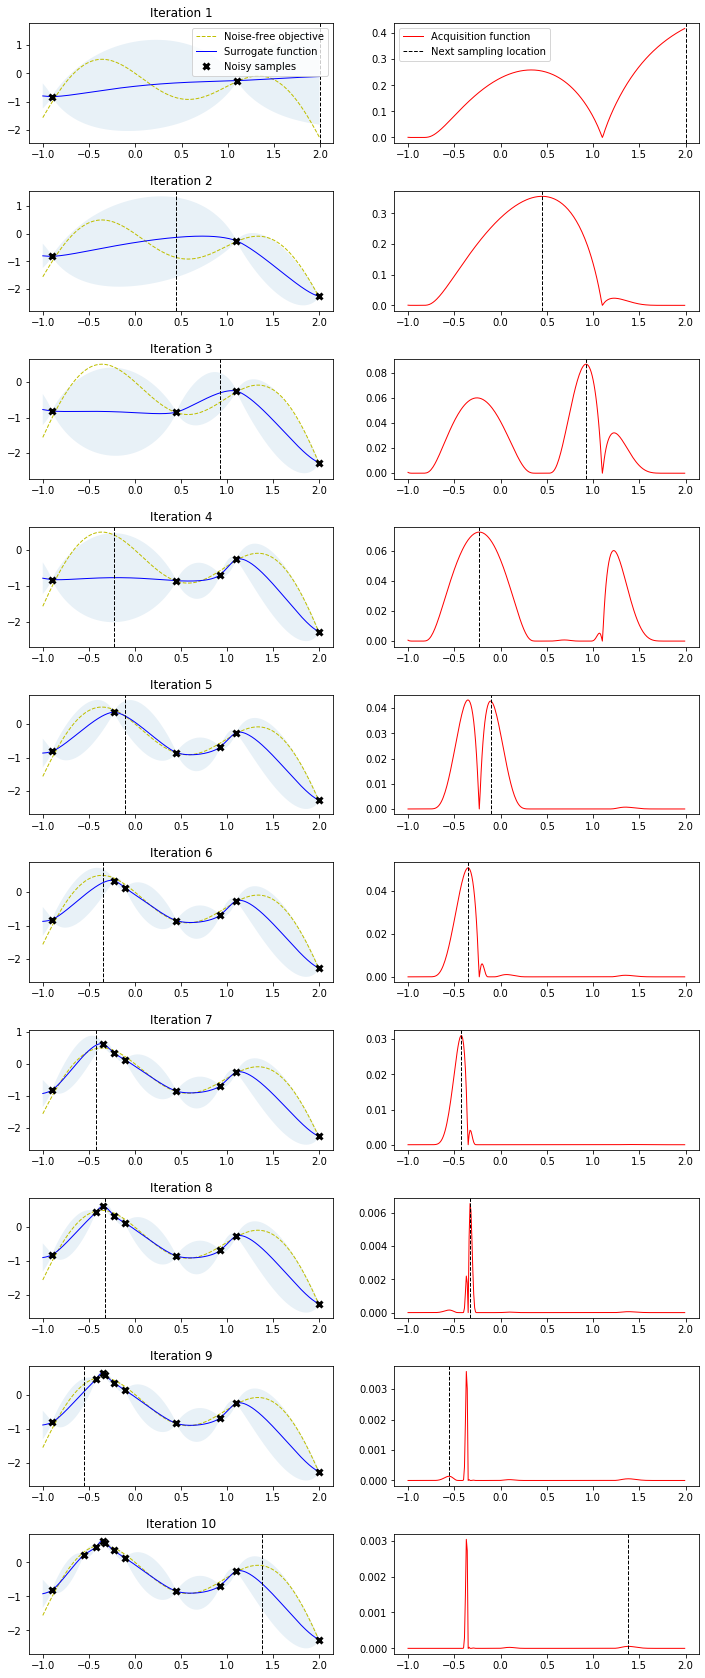

In [4]:
from acquisition import expected_improvement, maximise_acquisition
from gp_plot import plot_acquisition, plot_approximation

# Initialize samples
X_sample = np.array([[-0.9], [1.1]])
Y_sample = f(X_sample)

# Number of iterations to run Bayesian Optimization for
n_iter = 10

plt.figure(figsize=(12, n_iter * 3))
plt.subplots_adjust(hspace=0.4)

for i in range(n_iter):
    # Obtain next sampling point from the acquisition function (expected_improvement)
    X_next = maximise_acquisition(expected_improvement, bounds, X_sample, Y_sample, sigma_y=1e-6, kernel='matern')
    
    # Obtain next noisy sample from the objective function
    Y_next = f(X_next, noise)
    
    # Plot samples, surrogate function, noise-free objective and next sampling location
    plt.subplot(n_iter, 2, 2 * i + 1)
    plot_approximation(X, Y, X_sample, Y_sample, X_next, sigma_y=1e-6, kernel='matern', show_legend=i==0)
    plt.title(f'Iteration {i+1}')

    plt.subplot(n_iter, 2, 2 * i + 2)
    plot_acquisition(X, expected_improvement(X, X_sample, Y_sample, sigma_y=1e-6, kernel='matern'), X_next, show_legend=i==0)
    
    # Add sample to previous samples
    X_sample = np.vstack((X_sample, X_next))
    Y_sample = np.vstack((Y_sample, Y_next))